# Make Figure 3C

This notebook makes Figure 3C. It also shows how we calculated the number of trans proteins significant in only one cancer, the total number of trans genes, and the most significant gene. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest

import cptac

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Step 1: Load data and calculate std dev and mean for p values and correaltions

In [2]:
df_fdr_pvals = pd.read_csv("Make_Tables/csv_files/Supplemental_Table_2.csv")
df_fdr_pvals = df_fdr_pvals.set_index("Comparison")
df_fdr_pvals

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,Correlation_BR,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC
Comparison,,,,,,,,,,,,,,,,
PHLDA1,0.816848,3.507071e-21,0.254436,0.060261,NaN,NaN,0.260110,0.074530,0.713420,2.644826e-14,0.364797,0.002164,0.386104,0.122847,0.664271,8.888640e-12
GRB2,-0.610889,6.729990e-08,-0.217427,0.120342,-0.190090,0.346111,-0.302439,0.020631,-0.198042,2.437176e-01,-0.177379,0.142733,0.150960,0.347409,-0.532341,3.320092e-06
SOCS2,0.562720,3.420388e-06,NaN,NaN,NaN,NaN,NaN,NaN,0.472624,1.417921e-02,NaN,NaN,NaN,NaN,0.020297,9.557300e-01
CDH4,0.559180,3.420388e-06,0.148407,0.513490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAB2,-0.556402,3.420388e-06,-0.076173,0.673774,0.076981,0.750510,-0.086403,0.597546,-0.072496,7.501117e-01,0.326055,0.003543,-0.147519,0.360266,-0.208437,1.490980e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HEPHL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001563,9.959775e-01
CLEC4G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001142,9.968519e-01
ZNF502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000884,9.969615e-01


In [3]:
#Calculate mean and standard deviation for pvalues and Pearson Correlations
df_fdr_pvals["Standard_Deviation_P_value"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].std(axis = 1)
df_fdr_pvals["Mean_P_value"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].mean(axis = 1)
df_fdr_pvals["Standard_Deviation_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_GBM","Correlation_ccRCC","Correlation_OV","Correlation_BR","Correlation_LUAD","Correlation_HNSCC","Correlation_LSCC","Correlation_CO"]].std(axis = 1))
df_fdr_pvals["Mean_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_GBM","Correlation_ccRCC","Correlation_OV","Correlation_BR","Correlation_LUAD","Correlation_HNSCC","Correlation_LSCC","Correlation_CO"]].mean(axis = 1))


# Step 2: Calculate the number of significant cancers for each protein

In [4]:
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05:
            numSig += 1
            
    return numSig

In [5]:
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)

In [6]:
#Filter for proteins that are significant in at least 1 cancer. 
df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
df_fdr_pvals_1

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
LANCL2,0.478723,0.000091,0.188217,0.193598,0.110983,0.627956,0.588808,4.733914e-08,0.575817,2.040789e-07,...,7.599309e-03,0.320786,0.026823,0.796728,1.970503e-21,0.220706,0.107008,0.230333,0.420130,6
CD109,-0.361839,0.004379,0.268902,0.044632,0.015377,0.961793,0.113339,4.717738e-01,0.360461,7.836561e-03,...,2.042875e-02,0.297635,0.042193,0.514002,8.765469e-06,0.348547,0.194131,0.266765,0.184153,6
CNNM4,-0.372324,0.003168,0.069926,0.718877,0.076606,0.751602,0.270616,4.101591e-02,0.311652,3.142153e-02,...,2.329196e-02,0.352937,0.013936,0.284408,3.293176e-02,0.329428,0.202031,0.273997,0.091721,6
KIF13B,-0.143903,0.357780,-0.310972,0.016103,0.439778,0.009101,-0.272975,3.960258e-02,-0.363670,6.920009e-03,...,5.460232e-03,0.019902,0.918920,-0.440949,2.212241e-04,0.326279,0.169263,0.285396,-0.173143,6
MYO10,0.447478,0.000289,-0.263921,0.049045,0.374118,0.035041,0.230896,8.949836e-02,0.292466,4.901629e-02,...,5.191477e-07,NaN,NaN,0.370603,2.728434e-03,0.033619,0.032231,0.257917,0.281063,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARHGAP22,-0.431207,0.000500,-0.054868,0.827657,NaN,NaN,NaN,NaN,0.021890,9.490798e-01,...,4.622741e-01,NaN,NaN,NaN,NaN,0.426464,0.559878,0.241829,-0.085304,1
CSPG5,0.430729,0.000507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000507,NaN,0.430729,1
SIGLEC1,-0.187576,0.205012,-0.199631,0.163011,-0.028643,0.917324,-0.058913,7.376201e-01,-0.032904,9.027302e-01,...,7.294502e-01,0.265723,0.113908,-0.369997,2.759158e-03,0.384680,0.471477,0.189309,-0.070285,1


# Calculate the number of proteins significant in only one cancer

The manuscript mentions that 4,149/ 6,230 proteins are significant in only one cancer. This code block derives those numbers 

In [7]:
#print the number of genes significant in 1, 2, 3 ect cancers
counts = df_fdr_pvals_1['Num_sig'].value_counts()
counts

1    4149
2    1460
3     476
4     113
5      27
6       5
Name: Num_sig, dtype: int64

In [8]:
print("Total number of trans genes " + str(len(df_fdr_pvals_1)))

Total number of trans genes 6230


# Most consistent gene

This code block show the genes that are significant in 6 cancers. LANCL2 is the only one that doesn't have opposite trans effects in different cancers

In [9]:
df_fdr_pvals_6 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([6])]
df_fdr_pvals_6

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
LANCL2,0.478723,0.000091,0.188217,0.193598,0.110983,0.627956,0.588808,4.733914e-08,0.575817,2.040789e-07,...,7.599309e-03,0.320786,0.026823,0.796728,1.970503e-21,0.220706,0.107008,0.230333,0.420130,6
CD109,-0.361839,0.004379,0.268902,0.044632,0.015377,0.961793,0.113339,4.717738e-01,0.360461,7.836561e-03,...,2.042875e-02,0.297635,0.042193,0.514002,8.765469e-06,0.348547,0.194131,0.266765,0.184153,6
CNNM4,-0.372324,0.003168,0.069926,0.718877,0.076606,0.751602,0.270616,4.101591e-02,0.311652,3.142153e-02,...,2.329196e-02,0.352937,0.013936,0.284408,3.293176e-02,0.329428,0.202031,0.273997,0.091721,6
KIF13B,-0.143903,0.357780,-0.310972,0.016103,0.439778,0.009101,-0.272975,3.960258e-02,-0.363670,6.920009e-03,...,5.460232e-03,0.019902,0.918920,-0.440949,2.212241e-04,0.326279,0.169263,0.285396,-0.173143,6
MYO10,0.447478,0.000289,-0.263921,0.049045,0.374118,0.035041,0.230896,8.949836e-02,0.292466,4.901629e-02,...,5.191477e-07,NaN,NaN,0.370603,2.728434e-03,0.033619,0.032231,0.257917,0.281063,6


# Drop proteins that don't have data for atleast 6 out of 8 cancers 


In [10]:
df_fdr_pvals_1_subset = df_fdr_pvals_1.dropna(thresh = 17)


# Step 2: Make Figure 1 C

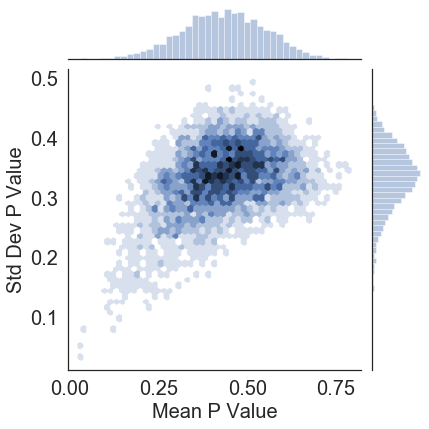

In [11]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_1_subset, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/EGFR_Fig_1C_Pvalue_sig_atleast1_cancer.png", dpi = 300)

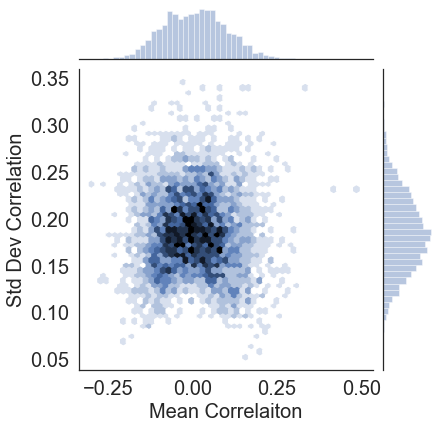

In [12]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_1_subset, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/EGFR_Fig_1C_Corr_atleast1_cancer.png", dpi = 300)
plt.show()

The following figures are supplemental and show the graphs restricted to proteins significant in at least 2 or 3 cancers. 

# Filter for genes significant in at least 2 Cancers 

In [13]:

df_fdr_pvals_2 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([2,3,4,5,6,7,8])]

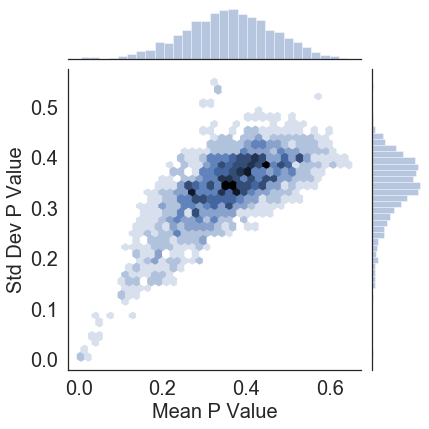

In [14]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/EGFR_Fig_1C_Pvalue_atleast2_cancers.png", dpi = 300)

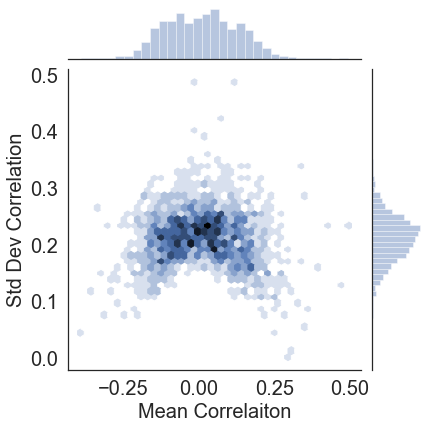

In [15]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/EGFR_Fig_1C_Corr_atleast2_cancers.png", dpi = 300)
plt.show()

# At least 3 Cancers

In [16]:

df_fdr_pvals_3 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([3,4,5,6,7,8])]

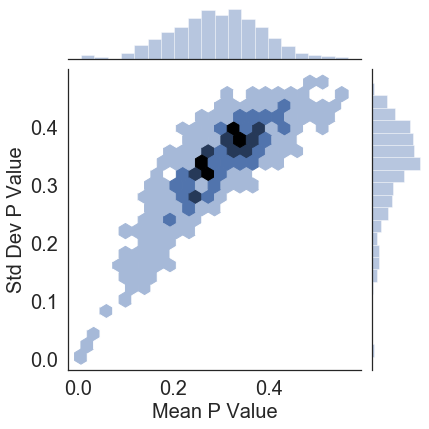

In [17]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_3, kind="hex", bins = 5)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/EGFR_Fig_1C_Pvalue_EGFR_atleast3_cancers.png", dpi = 300)

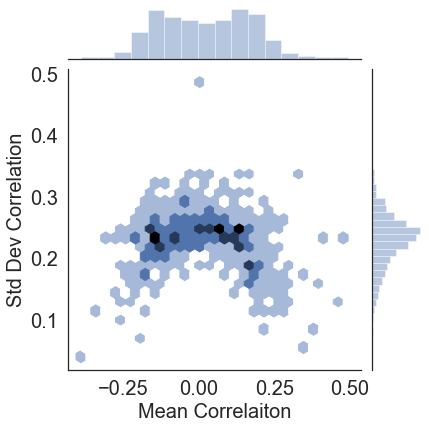

In [18]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_3, kind="hex", bins = 5)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/EGFR_Fig_1C_Corr_EGFR_atleast3_cancers.png", dpi = 300)
plt.show()

# Single Gene Example PLAU

In [20]:
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)

In [21]:

df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
df_fdr_pvals_1

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
LANCL2,0.478723,0.000091,0.188217,0.193598,0.110983,0.627956,0.588808,4.733914e-08,0.575817,2.040789e-07,...,7.599309e-03,0.320786,0.026823,0.796728,1.970503e-21,0.220706,0.107008,0.230333,0.420130,6
CNNM4,-0.372324,0.003168,0.069926,0.718877,0.076606,0.751602,0.270616,4.101591e-02,0.311652,3.142153e-02,...,2.329196e-02,0.352937,0.013936,0.284408,3.293176e-02,0.329428,0.202031,0.273997,0.091721,6
KIF13B,-0.143903,0.357780,-0.310972,0.016103,0.439778,0.009101,-0.272975,3.960258e-02,-0.363670,6.920009e-03,...,5.460232e-03,0.019902,0.918920,-0.440949,2.212241e-04,0.326279,0.169263,0.285396,-0.173143,6
MYO10,0.447478,0.000289,-0.263921,0.049045,0.374118,0.035041,0.230896,8.949836e-02,0.292466,4.901629e-02,...,5.191477e-07,NaN,NaN,0.370603,2.728434e-03,0.033619,0.032231,0.257917,0.281063,6
CD109,-0.361839,0.004379,0.268902,0.044632,0.015377,0.961793,0.113339,4.717738e-01,0.360461,7.836561e-03,...,2.042875e-02,0.297635,0.042193,0.514002,8.765469e-06,0.348547,0.194131,0.266765,0.184153,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAM105A,NaN,NaN,NaN,NaN,0.128236,0.559517,NaN,NaN,NaN,NaN,...,6.632103e-04,-0.225344,0.134947,NaN,NaN,0.291722,0.231709,0.332112,0.113766,1
TICRR,NaN,NaN,NaN,NaN,NaN,NaN,-0.305557,3.983447e-02,-0.049310,8.550018e-01,...,8.617193e-01,NaN,NaN,-0.048371,8.637975e-01,0.410186,0.655088,0.147084,-0.092614,1
ATP2B4_1,NaN,NaN,NaN,NaN,0.120229,0.588475,NaN,NaN,NaN,NaN,...,4.309139e-02,NaN,NaN,NaN,NaN,0.385645,0.315783,0.081468,0.177835,1


In manuscript, a single gene (PLAU) from the histogram figure is mentioned. Here are the correlations and pvalues as well as the average and std dev for the p values and correlations. See WhenMutationsDontMatter/EGFR/Make_supplemental_Figures_and_Tables/Make_Sup_Fig_2_PLAU for notebook that graphs pearson correlations. 

In [22]:
rowData = df_fdr_pvals_1.loc[ 'PLAU' , : ]
rowData

Correlation_GBM                  -0.278913
P_value_GBM                       0.039473
Correlation_ccRCC                -0.041226
P_value_ccRCC                     0.893600
Correlation_OV                    0.003476
P_value_OV                        0.991874
Correlation_LUAD                  0.181156
P_value_LUAD                      0.205032
Correlation_LSCC                  0.412139
P_value_LSCC                      0.001281
Correlation_BR                    0.369332
P_value_BR                        0.000802
Correlation_CO                    0.233998
P_value_CO                        0.190092
Correlation_HNSCC                 0.451865
P_value_HNSCC                     0.000148
Standard_Deviation_P_value        0.411952
Mean_P_value                      0.290288
Standard_Deviation_Correlation    0.255176
Mean_Correlation                  0.166478
Num_sig                           4.000000
Name: PLAU, dtype: float64